In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mip import Model, minimize, BINARY, INTEGER, CONTINUOUS, xsum
import json
from pulp import *
from scipy.stats import norm
from scipy.spatial import distance_matrix

In [3]:
df = pd.read_csv("C:\\Users\\saiei\\OneDrive\\Desktop\\Supply Chain Analytics\\E Commerce Shipping Data.csv")
df

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached_on_time,Transport_cost,latitude,logitude
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,6.0,-29.608965,30.409992
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,42.0,-37.897421,145.005567
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,6.5,-37.789176,144.940031
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,6.5,-37.832171,145.269370
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,7.0,-29.822347,30.806909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,135,A,Flight,3,3,168,2,medium,F,1,1829,1,44.2,41.672585,-72.536819
135,136,B,Flight,3,5,157,3,medium,F,4,1889,1,6.0,41.416186,-73.281779
136,137,C,Flight,3,3,189,4,medium,F,51,2208,1,6.5,41.416186,-73.281779
137,138,F,Flight,3,5,162,2,medium,M,7,1739,1,4.5,44.413900,-68.587200


In [5]:
len(df)

139

In [7]:
poly = pd.read_csv("C:\\Users\\saiei\\Downloads\\baun675_lecture1_poly.csv")
poly

,x,y
0,133.008694,-48.989165
1,163.819315,102.525835
2,90.938980,70.619722
3,-11.851242,111.319803
4,-123.204140,51.122915
5,-175.910163,34.476617
6,-106.339232,-28.849643
7,-82.627501,-136.079358
8,73.578771,-144.328847
9,82.589031,-75.398005


(-200.0, 200.0, -150.0, 150.0)

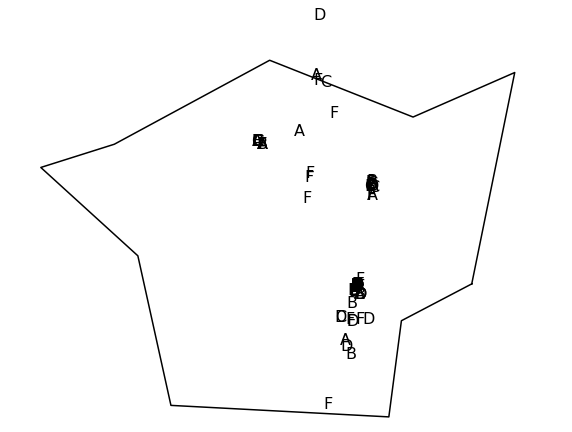

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(df['latitude'], df['logitude'], s=df['Customer_rating']//30)
plt.plot(poly['x'], poly['y'], 'k-')

for i in range(len(df)):
    ax.annotate(df.iloc[i]['Warehouse_block'], [df.iloc[i]['latitude']+5, df.iloc[i]['logitude']+20], fontsize=16)
plt.axis('square')
plt.axis([-200, 200, -150, 150])
plt.axis('off')

In [10]:
num = (df['Customer_rating'] * df['latitude']).sum()
den = df['Customer_rating'].sum()
latitude = num/den
latitude

25.783111280592415

In [11]:
num = (df['Customer_rating'] * df['logitude']).sum()
den = df['Customer_rating'].sum()
logitude = num /den
logitude

-24.825844288175357

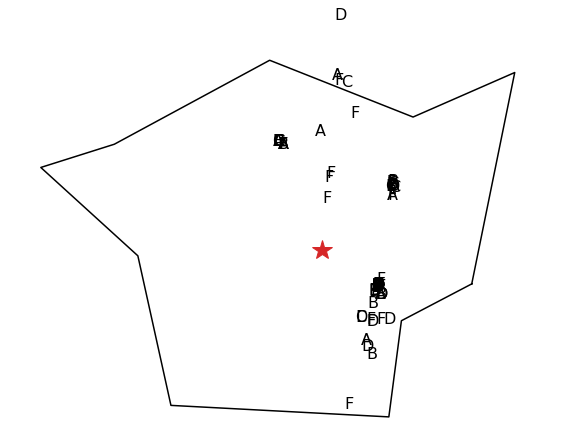

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(df['latitude'], df['logitude'], s=df['Customer_rating']//30)
plt.plot(poly['x'], poly['y'], 'k-')

for i in range(len(df)):
    ax.annotate(df.iloc[i]['Warehouse_block'], df.iloc[i][['latitude', 'logitude']].values + 20, fontsize=16)
plt.axis('square')
plt.axis([-200, 200, -150, 150])
plt.axis('off')
plt.plot(latitude, logitude, '*', color='C3', markersize=20)

In [90]:
# Transportation Optimization Dummy Model 


from pulp import *

# Create problem variable
problem = LpProblem("Transportation Optimization", LpMinimize)

# Define decision variables
warehouse_block = ["Warehouse A", "Warehouse B", "Warehouse C", "Warehouse D"]
mode_of_shipment = ["Flight", "Ship", "Road"]
cost_of_product = {"Product A": 10, "Product B": 15, "Product C": 20}
weight_in_gms = {"Product A": 1000, "Product B": 2000, "Product C": 3000}
shipment_vars = LpVariable.dicts("Shipments", ((w, m, p) for w in warehouse_block for m in mode_of_shipment for p in cost_of_product), lowBound=0, cat='Integer')

# Define objective function
problem += lpSum([shipment_vars[w, m, p] * cost_of_product[p] for w in warehouse_block for m in mode_of_shipment for p in cost_of_product])

# Define capacity constraints
for w in warehouse_block:
    problem += lpSum([shipment_vars[w, m, p] * weight_in_gms[p] for m in mode_of_shipment for p in cost_of_product]) <= 100000 # Maximum capacity constraint

# Define product shipment constraint
for p in cost_of_product:
    problem += lpSum([shipment_vars[w, m, p] for w in warehouse_block for m in mode_of_shipment]) == 1 # Product shipment constraint

# Solve problem
problem.solve()

# Print results
print("Status: ", LpStatus[problem.status])
for w in warehouse_block:
    for m in mode_of_shipment:
        for p in cost_of_product:
            if shipment_vars[w, m, p].varValue != 0:
                print("Shipment from ", w, " by ", m, " of product ", p, ": ", shipment_vars[w, m, p].varValue)
print("Total cost of shipment: ", value(problem.objective))


Status:  Optimal
Shipment from  Warehouse D  by  Flight  of product  Product A :  1.0
Shipment from  Warehouse D  by  Flight  of product  Product B :  1.0
Shipment from  Warehouse D  by  Flight  of product  Product C :  1.0
Total cost of shipment:  45.0


In [20]:
# Transportation Optimization Model 


from pulp import *

problem = LpProblem("Transportation Optimization", LpMinimize)

# Define the decision variables
warehouse_block = df['Warehouse_block'].unique()
mode_of_shipment = df['Mode_of_Shipment'].unique()
cost_of_transport = dict(zip(df['Transport_cost'].unique(), df['Transport_cost'].unique()))
weight_in_gms = dict(zip(df['Transport_cost'].unique(), df['Weight_in_gms'].unique()))

# Define the shipment decision variable matrix
shipment_vars = LpVariable.dicts("Shipments", ((w, m) for w in warehouse_block for m in mode_of_shipment), lowBound=0, cat='Integer')

# Define the objective function
problem += lpSum([shipment_vars[w, m] * cost_of_transport[p] for p in cost_of_transport for w in warehouse_block for m in mode_of_shipment])

# Define the constraints
for w in warehouse_block:
    problem += lpSum([shipment_vars[w, m] for m in mode_of_shipment]) <= 1000  # Maximum capacity constraint

for p in cost_of_transport:
    problem += lpSum([shipment_vars[w, m] for w in warehouse_block for m in mode_of_shipment if p in cost_of_transport]) == 1  # Product shipment constraint

problem.solve()


print("Status: ", LpStatus[problem.status])
for w in warehouse_block:
    for m in mode_of_shipment:
        print("Shipment from ", w, " by ", m, ": ", shipment_vars[w, m].varValue)


Status:  Optimal
Shipment from  D  by  Flight :  0.0
Shipment from  D  by  Ship :  0.0
Shipment from  D  by  Road :  0.0
Shipment from  F  by  Flight :  0.0
Shipment from  F  by  Ship :  1.0
Shipment from  F  by  Road :  0.0
Shipment from  A  by  Flight :  0.0
Shipment from  A  by  Ship :  0.0
Shipment from  A  by  Road :  0.0
Shipment from  B  by  Flight :  0.0
Shipment from  B  by  Ship :  0.0
Shipment from  B  by  Road :  0.0
Shipment from  C  by  Flight :  0.0
Shipment from  C  by  Ship :  0.0
Shipment from  C  by  Road :  0.0
